Neste projeto, você deve prever o Customer Churn em uma Operadora de Telecom.
Será criado um projeto de Regressão Logística com o PySpark - segundo recomendação - para prever se um cliente pode (sim = 1) ou não (0) cancelar seu plano.

Utilizei o Java 1.8 e Spark 2.4.2

# Importando Pacotes e explorando o Dataset

In [16]:
# imports
import math
from pyspark.sql import SparkSession
import seaborn as sns

In [2]:
# Vou usar o Pandas para explorar o Dataset.
import pandas as pd
df = pd.read_csv('projeto4_telecom_treino.csv')

In [3]:
# Dimensões do dataset
df.shape

(3333, 21)

In [4]:
# Visualizar dataset
df.head(5)

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [5]:
# Verificando se existem dados missing
df.isnull().any()

Unnamed: 0                       False
state                            False
account_length                   False
area_code                        False
international_plan               False
voice_mail_plan                  False
number_vmail_messages            False
total_day_minutes                False
total_day_calls                  False
total_day_charge                 False
total_eve_minutes                False
total_eve_calls                  False
total_eve_charge                 False
total_night_minutes              False
total_night_calls                False
total_night_charge               False
total_intl_minutes               False
total_intl_calls                 False
total_intl_charge                False
number_customer_service_calls    False
churn                            False
dtype: bool

In [105]:
# Excluindo a coluna 0, pois é meramente indice.
df = df.drop('Unnamed: 0',axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000185E2206BE0>,
      dtype=object)

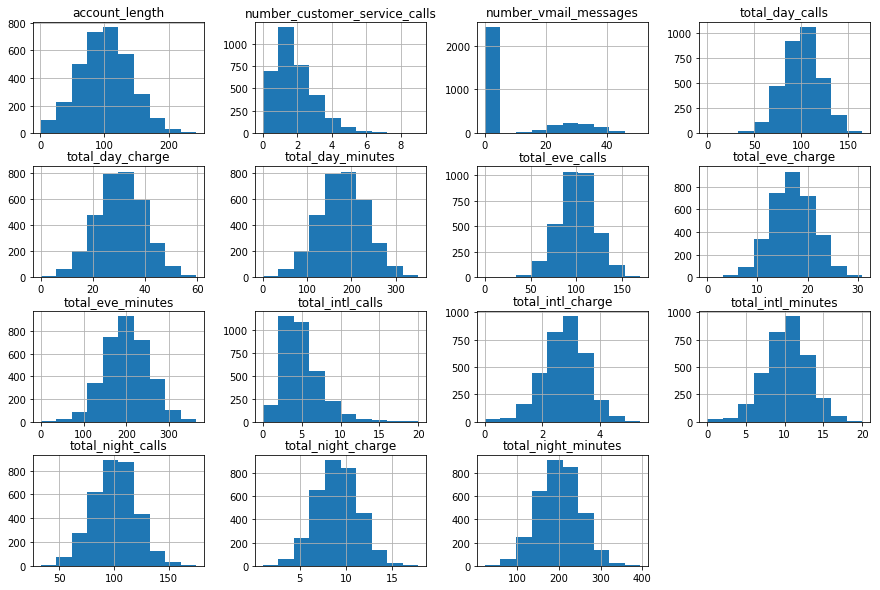

In [106]:
# Histogramas de todas as variáveis do dataset.
df.hist(figsize = (15,10))

O dataset acima tem diversas variáves com distribuições normais.

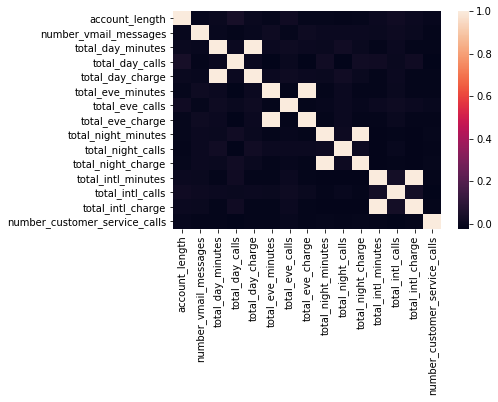

In [110]:
# Mapa de calor das correlações entre as variáveis.
sns.heatmap(df.corr())

Do heatmap acima, podemos perceber que as variáveis total_day/eve/night_charges são colineares com seus pares total_day/eve/night_minutes, o que faz todo o sentido, visto que a cobrança de telefonemas é feita por minutos. Logo, podemos retirar os charges ou os minutos no momento de criar o modelo.

In [27]:
# Percentual da distribuição da variável target 'Churn'.
# Percebemos claro desbalanceamento.
df['churn'].value_counts(normalize=True)*100

no     85.508551
yes    14.491449
Name: churn, dtype: float64

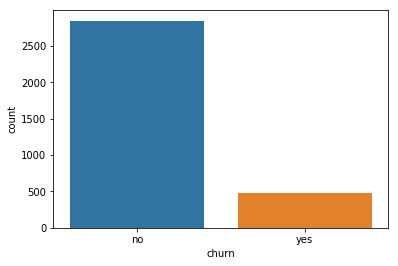

In [17]:
# Plot da variável target
sns.countplot(x='churn', data=df)

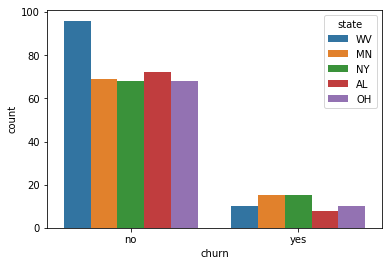

In [65]:
# Plot para visualizar fidelidade dos clientes por estado (5 maiores counts)
sns.countplot(x='churn', hue='state', data=df, hue_order=df.state.value_counts().iloc[:5].index)

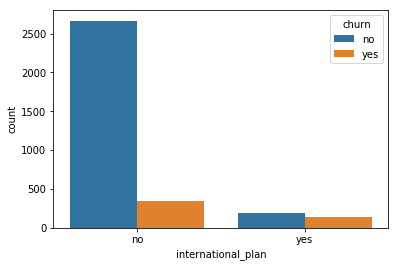

In [73]:
sns.countplot(x='international_plan', hue='churn', data=df)

Text(0.5, 1.0, 'Período mais propenso para ocorrer o Churn')

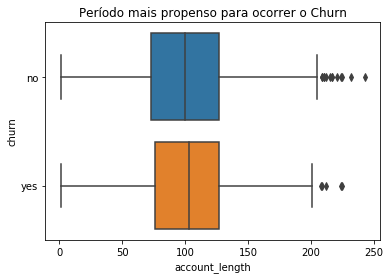

In [98]:
# Abaixo no gráifco podemos ver em qual quantidade de dias mais ocorre os cancelamentos
# Pelo BoxPlot de Churn='YES', vemos que os valores estão entre 80 e 130 -> 3 e 6 meses mais ou menos
sns.boxplot(y='churn', x='account_length', data=df).set_title('Período mais propenso para ocorrer o Churn')

Text(0.5, 1.0, 'Minutos falados Noite vs Fidelidade')

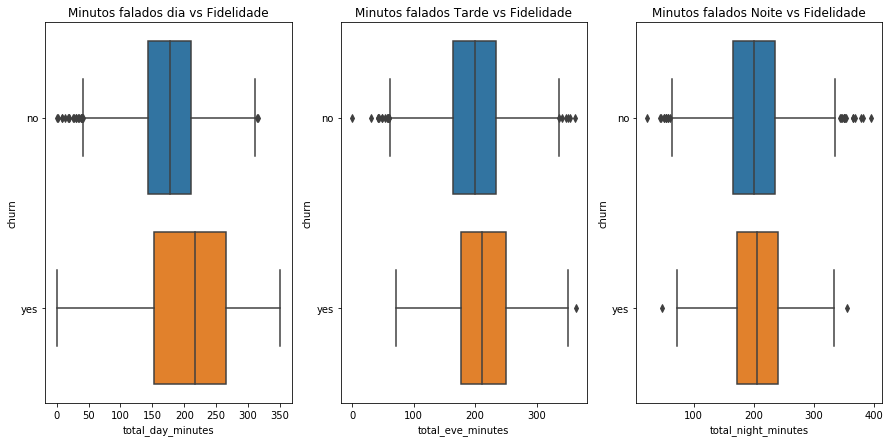

In [124]:
# Visualização do perfil de uso (minutos falados) das pessoas e sua fidelidade.
fig, axs = plt.subplots(ncols=3, figsize = (15,7))
sns.boxplot(y='churn', x='total_day_minutes', data=df, ax=axs[0]).set_title('Minutos falados dia vs Fidelidade')
sns.boxplot(y='churn', x='total_eve_minutes', data=df, ax=axs[1]).set_title('Minutos falados Tarde vs Fidelidade')
sns.boxplot(y='churn', x='total_night_minutes', data=df, ax=axs[2]).set_title('Minutos falados Noite vs Fidelidade')


Percebemos que a maioria das pessoas que saem da empresa são, em geral, heavy users do serviço.
Em média, os clientes que optam por trocar de empresa falam mais de 150 minutos, independentemente do período do dia.

# Spark Session

In [203]:
# Criando a Spark session
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("LogRegr-Projeto4").getOrCreate()

In [204]:
# Carregando o dataset e imprimindo o Schema, o qual nos mostra as colunas com nomes e tipos de dados.
new_df = spark.read.csv('projeto4_telecom_treino.csv', header=True, inferSchema=True)
new_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churn: string (nullable = t

In [205]:
# Remover colunas 0 e area_code
drop_col = ['_c0', 'area_code']
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])
new_df.groupby('churn').count().toPandas()

,churn,count
0,no,2850
1,yes,483


In [206]:
# Transformando os dados de Churn em 0 para No e 1 para Yes.
from pyspark.sql.functions import when
def binarizar(labels):
    return when(labels == 'yes', 1).otherwise(0)
new_df = new_df.withColumn('label', binarizar(new_df['churn']))

In [207]:
# Remover coluna Categórica Churn.
drop_col = ['churn']
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])

In [208]:
# Listando as variáveis categóricas e numéricas
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

3  categorical features
15  numerical features


In [209]:
# Inserir nova coluna com pesos para balancear a variável target
ratio = 0.85
def weight_balance(labels):
    return when(labels == '1', ratio).otherwise(1*(1-ratio))
new_df = new_df.withColumn('weights', weight_balance(new_df['label']))

In [210]:
# Usando o OneHotEncoderEstimator da MLlib Spark para converter as variáveis categoricas em números (one-hot vectors)
# Depois, usaremos o VectorAssembler para combinar o vetor resultante do one-hot com o restante das variáveis numéricas 
# em um único vetor.
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [211]:
# Agora usamos um Pipeline para realizar todas as operações
from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

,features,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,label,weights
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",KS,128,no,yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0.15
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",OH,107,no,yes,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.15
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NJ,137,no,no,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.15
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",OH,84,yes,no,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0.15
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",OK,75,yes,no,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.15


In [212]:
# Fazer split dos dados em Treino e Teste sets
train, test = new_df.randomSplit([0.70, 0.3], seed = 1)
print('Treino:', train.count())
print('Teste:', test.count())

Treino: 2321
Teste: 1012


In [213]:
# Criando o modelo de Regressão Logística
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

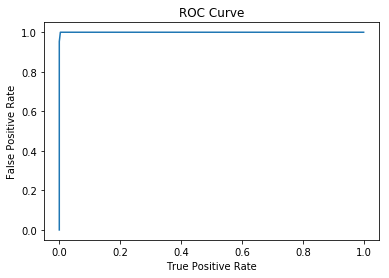

Training set ROC: 0.9999164495847843


In [214]:
# Plotando o ROC Curve para ver a performance do modelo de RL
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [215]:
# Print da performance do modelo
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 1.0


In [218]:
# Confusion Matrix
predictions_LR.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  867|
|    1|       1.0|  145|
+-----+----------+-----+

